In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
#Akaze is better? http://poly.hatenablog.com/entry/2014/01/06/063012
def getMatchedPoints(img1,img2):
    # ORB (Oriented FAST and Rotated BRIEF)
    #detector = cv2.ORB_create(nfeatures=500,scoreType=cv2.ORB_HARRIS_SCORE)
    detector = cv2.AKAZE_create()
    #detector = cv2.KAZE_create()


    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    kp1,des1 = detector.detectAndCompute(img1,None)
    kp2,des2 = detector.detectAndCompute(img2,None)

    # Match descriptors.
    #https://stackoverflow.com/questions/31690265/matching-features-with-orb-python-opencv
    matches = bf.knnMatch(des1,des2,k=2)

    good = []
    pts1 = []
    pts2 = []
   
    count = 0
    for m,n in matches:      
        if m.distance < 0.5*n.distance:
            good.append([m])
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt) 
            count+=1
    print(count)
    # https://stackoverflow.com/questions/31631352/typeerror-required-argument-outimg-pos-6-not-found
    #img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:count],None, flags=2)
    #cv2.imshow("matching",img3)
    #cv2.waitKey(0)
   
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3=cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
    plt.imshow(img3),plt.show()
    cv2.imwrite("matched.jpg", img3)
    return pts1,pts2

In [56]:
# Loading exposure images into a list
# There is no reason to decide exposure value
img_fn = ["bright.jpg", "dark.jpg"]
img_list = [cv2.imread(fn) for fn in img_fn]
exposure_times = np.array([2.4, 1], dtype=np.float32)

1469


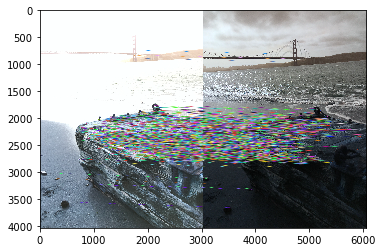

In [5]:
[pts1, pts2] = getMatchedPoints(img_list[0],img_list[1])

In [6]:
# take a rest
np.savetxt('pts1.csv',pts1,delimiter=',')
np.savetxt('pts2.csv',pts2,delimiter=',')

In [7]:
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

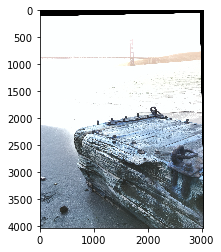

True

In [8]:
Imsize=(img_list[0].shape[1],img_list[0].shape[0])
im_dst = cv2.warpPerspective(img_list[0], H, Imsize)
plt.imshow(im_dst),plt.show()
cv2.imwrite("bright_rev.jpg", im_dst)

In [9]:
def Rendering(img_list,exposure_times):
    # Merge exposures to HDR image
    merge_debvec = cv2.createMergeDebevec()
    hdr_debvec = merge_debvec.process(img_list, times=exposure_times.copy())
    merge_robertson = cv2.createMergeRobertson()
    hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())
    
    # Tonemap HDR image
    tonemap1 = cv2.createTonemapDurand(gamma=2.2)
    res_debvec = tonemap1.process(hdr_debvec.copy())
    tonemap2 = cv2.createTonemapDurand(gamma=1.3)
    res_robertson = tonemap2.process(hdr_robertson.copy())

     # Exposure fusion using Mertens
    merge_mertens = cv2.createMergeMertens()
    res_mertens = merge_mertens.process(img_list)

     # Convert datatype to 8-bit and save
    res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
    res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')
    res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')

    cv2.imwrite("ldr_debvec.jpg", res_debvec_8bit)
    cv2.imwrite("ldr_robertson.jpg", res_robertson_8bit)
    cv2.imwrite("fusion_mertens.jpg", res_mertens_8bit)

In [57]:
new_list = [im_dst,img_list[1]]
Rendering(new_list,exposure_times)

In [50]:
pts1_aft=np.dot( H,np.hstack([pts1,np.ones((pts1.shape[0],1))]).T )
gimg1=cv2.cvtColor(img_list[0], cv2.COLOR_BGR2GRAY)
gimg2=cv2.cvtColor(img_list[1], cv2.COLOR_BGR2GRAY)

In [51]:
g1sum=0
g2sum=0

for p1 in pts1:
#    x1=int(round(p1[0]/p1[2]))
#    y1=int(round(p1[1]/p1[2]))
    x1=int(round(p1[0]))
    y1=int(round(p1[1]))
    g1sum = g1sum + gimg1[y1,x1]
    
for p2 in pts2:
    x2=int(round(p2[0]))
    y2=int(round(p2[1]))
    g2sum = g2sum + gimg2[y2,x2]
    

In [52]:
g1sum

271395

In [53]:
g2sum

112500

In [55]:
g1sum/g2sum

2.4123999999999999